In [28]:
!pip -q install rdkit-pypi scikit-learn pandas numpy matplotlib datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import Descriptors, rdMolDescriptors

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RDLogger.DisableLog('rdApp.*')


In [29]:
def smiles_to_mol(s):
    return Chem.MolFromSmiles(s)

def basic_descriptors(mol):
    return {
        "MolWt": Descriptors.MolWt(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "RingCount": rdMolDescriptors.CalcNumRings(mol),
    }

def morgan_bitvect(mol, radius=2, n_bits=1024):
    try:
        from rdkit.Chem import rdFingerprintGenerator as FG
        gen = FG.GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = gen.GetFingerprint(mol)
    except:
        from rdkit.Chem import AllChem
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def featurize_smiles(smiles_list, radius=2, n_bits=1024):
    bit_rows, desc_rows = [], []
    for s in smiles_list:
        mol = smiles_to_mol(s)
        if mol is None:
            continue
        bit_rows.append(morgan_bitvect(mol, radius, n_bits))
        desc_rows.append(basic_descriptors(mol))

    desc_keys = list(desc_rows[0].keys())
    X_desc = np.array([[d[k] for k in desc_keys] for d in desc_rows], dtype=float)
    X_bits = np.array(bit_rows, dtype=int)
    X = np.hstack([X_bits, X_desc])
    return X, desc_keys


In [30]:
!pip install datasets

from datasets import load_dataset
dataset = load_dataset("zpn/delaney")

train_df = pd.DataFrame(dataset["train"])[["smiles","target"]]
valid_df = pd.DataFrame(dataset["validation"])[["smiles","target"]]
test_df  = pd.DataFrame(dataset["test"])[["smiles","target"]]


In [31]:
X_train, desc_keys = featurize_smiles(train_df["smiles"].tolist())
y_train = train_df["target"].values

X_valid, _ = featurize_smiles(valid_df["smiles"].tolist())
y_valid = valid_df["target"].values

X_test, _ = featurize_smiles(test_df["smiles"].tolist())
y_test = test_df["target"].values


In [32]:
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
En iyi parametreler: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [33]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.428
RMSE: 0.580
R²: 0.680


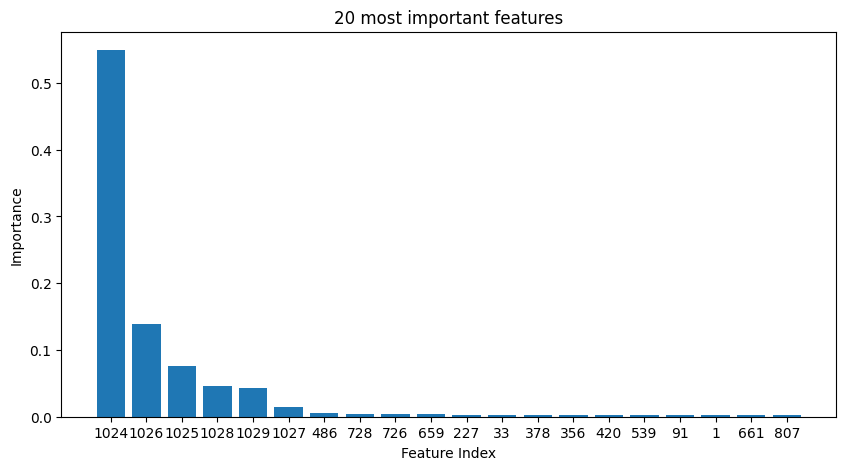

In [40]:

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
plt.figure(figsize=(10,5))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), indices[:top_n])
plt.title("20 most important features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


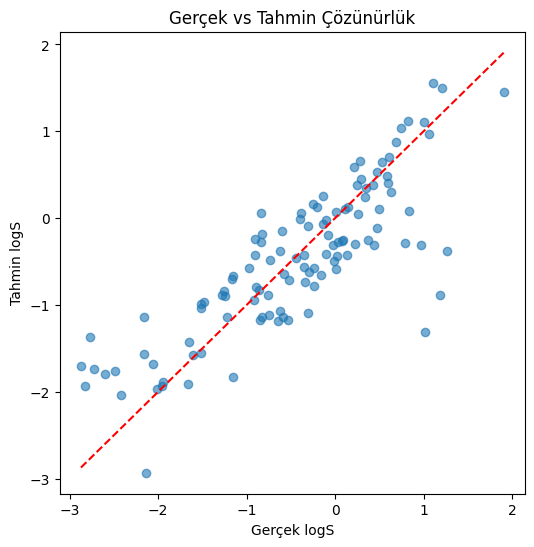

In [35]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Gerçek logS")
plt.ylabel("Tahmin logS")
plt.title("Gerçek vs Tahmin Çözünürlük")
plt.show()
